### Principal Component Regression

The SVD of the centered matrix $\mathbf{X}$ is another way of expressing the *principal components* of the variables in $\mathbf{X}$ where the sample covariance matrix is given by $\mathbf{S} = \mathbf{X}^\top\mathbf{X} / N$. Using the SVD of $\mathbf{X}$ we obtain:

$$\mathbf{X}^\top\mathbf{X} = \mathbf{V}\mathbf{D}^2\mathbf{V}^\top$$

which is the eigen decomposition of $\mathbf{X}^\top\mathbf{X}$ and of $\mathbf{S}$ up to a factor $N$.

The columns of $\mathbf{V}$ (the eigenvectors $v_j$) are also called the principal compinents directions of $\mathbf{X}$.

The first principal component direction $v_1$ has the property that $\mathbf{z}_1 = \mathbf{X}v_1 = \mathbf{u}_1 d_1$ has the largest sample variance amongs all normalized linear combinations of $\mathbf{X}$, and the last principle component direction $v_p$ has the property that $\mathbf{z}_p = \mathbf{X}v_p = \mathbf{u}_p d_p$ has the smallest sample variance amongs all normalized linear combinations of $\mathbf{X}$.

The variance of $z$ is given as:

$$\text{Var}(z_j) = \text{Var}(\mathbf{X}v_j) = \frac{d_j^2}{N}$$

In [38]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from ml_datasets.esl import ProstateCancer
# from esl.utils import scale
from esl.chapter03 import kfold, LeastSquaresRegression, RidgeRegression

In [39]:
def scale(x):
    mean = x.values.mean(axis=0, keepdims=True)
    stdev = x.values.std(axis=0, keepdims=True, ddof=0)
    return np.divide(np.subtract(x, mean), stdev)

In [40]:
prostate_cancer = ProstateCancer(verbose=0)
df = prostate_cancer.load()

In [41]:
train_test = prostate_cancer.train_test
df_x = df[prostate_cancer.meta[:-1]]
df_y = df[prostate_cancer.meta[-1]]

x_train = scale(df_x[train_test == 'T'].copy()).values
y_train =  df_y[train_test == 'T'].copy().values

In [42]:
class PrincipalComponentRegression:
    def __init__(self, **kwargs):
        self.num_components = kwargs.get('num_components', 1)
        self.mean_y = kwargs.get('mean_y', 0)

    def fit(self, x, y):     
        xTx = x.T @ x
        v, d2, vt = np.linalg.svd(xTx)

        beta = np.zeros((x.shape[1], x.shape[1]))
        for m in range(self.num_components):
            z_m = x @ v[:, m]
            theta_m = np.inner(z_m, y) / d2[m]
            beta[:, m] = theta_m * v[:, m]
            
        self.beta_hat = np.sum(beta, axis=1)
        
    def predict(self, x):
        return x @ self.beta_hat  #  + self.mean_y
    
    def error(self, x, y):
        y_hat = self.predict(x)
        return ((y - y_hat).T @ (y - y_hat)), ((y - y_hat).T @ (y - y_hat)) / len(y)

In [43]:
y_train_temp = y_train - np.mean(y_train)
x_dict, y_dict = kfold(x_train, y_train_temp, nfold=10, seed=2)
num_components = np.arange(x_train.shape[1] + 1)
RSS = dict()
MRSS = dict()

for m in num_components:
    RSS_temp = []
    MRSS_temp = []
    
    for fold in x_dict.keys():
        if m == 0:
            y_train_temp = y_dict[fold]['train'].copy()
            y_val_temp = y_dict[fold]['val'].copy()
            error = (y_val_temp).T @ (y_val_temp)
            merror = error / len(y_val_temp)
            
        else:
            x_train_temp = x_dict[fold]['train'].copy()
            x_val_temp = x_dict[fold]['val'].copy()

            y_train_temp = y_dict[fold]['train'].copy()
            y_val_temp = y_dict[fold]['val'].copy()
            
            pcr = PrincipalComponentRegression(num_components=m, intercept=False, mean_y=np.mean(y_train))
            pcr.fit(x_train_temp, y_train_temp)
            error, merror = pcr.error(x_val_temp, y_val_temp)

        RSS_temp.append(error)
        MRSS_temp.append(merror)
        
    RSS[m] = RSS_temp
    MRSS[m] = MRSS_temp

In [62]:
x_cv = np.array(list(RSS.keys()))

# calculate the mean of MSE from the 10-fold cross validation
y_cv_mean = np.array([np.mean(MRSS[key]) for key in MRSS.keys()])

# calculate the standard error
y_cv_std = np.array([np.std(MRSS[key]) / (10 ** 0.5) for key in MRSS.keys()])
print(y_cv_std)
print(y_cv_mean - y_cv_std)
# print(np.sqrt(y_cv_std / 2))
# y_cv_std = np.sqrt(y_cv_std / 2)
# find the most parsimonious model
upper_bound = np.min(y_cv_mean) + y_cv_std[np.argmin(y_cv_mean)]
best_dir = np.min(np.where(y_cv_mean <= upper_bound)[0])

[0.19090758 0.15178052 0.14436751 0.08186238 0.08075297 0.07895216
 0.06727304 0.07873617 0.07742499]
[1.22887848 0.66388496 0.63896212 0.61146188 0.58840771 0.60469278
 0.64333648 0.55435532 0.48014942]


(Figure 3.7 - Middle Right):

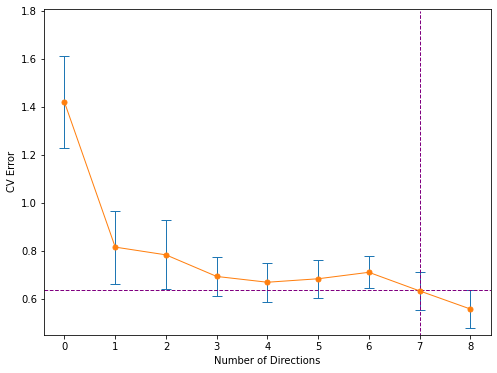

In [61]:
plt.figure(figsize=(8, 6))
plt.errorbar(x_cv, y_cv_mean, yerr=y_cv_std, capsize=5, ecolor='C0', color='C1', elinewidth=1, linewidth=1, marker='o', markersize=5)
x_cvv = np.linspace(-0.4, 8.4, 20)
y_cvv = np.linspace(0.4, 1.8, 20)

# this is to plot the purple horizontal line
plt.plot(x_cvv, upper_bound * np.ones(len(x_cvv)), '--', color='purple', linewidth=1)

# this is to plot the purple vertical line
plt.plot(best_dir * np.ones(len(y_cvv)), y_cvv, '--', color='purple', linewidth=1)

plt.xlim([-0.4, 8.4])
plt.ylim([0.45, 1.81])
plt.xlabel('Number of Directions')
plt.ylabel('CV Error')
plt.show()

In [36]:
pcr = PrincipalComponentRegression(num_components=best_dir, intercept=False, mean_y=np.mean(y_train))
y_train_temp = y_train - np.mean(y_train)
pcr.fit(x_train, y_train_temp)

# some formatting to make the table prettier
beta_0 = np.mean(y_train)
beta = np.append(beta_0, pcr.beta_hat)
best_coeff_dframe = pd.DataFrame({'PCR': beta})
best_coeff_dframe = best_coeff_dframe.apply(lambda x: x.map('{:10.3f}'.format))
best_coeff_dframe['Term'] = ['Intercept'] + list(prostate_cancer.meta[:-1])
cols = best_coeff_dframe.columns[::-1]
best_coeff_dframe = best_coeff_dframe[cols]
best_coeff_dframe

,Term,PCR
0,Intercept,2.452
1,lcavol,0.566
2,lweight,0.321
3,age,-0.153
4,lbph,0.214
5,svi,0.320
6,lcp,-0.050
7,gleason,0.227
8,pgg45,-0.063


In [37]:
x_test = scale(df_x[train_test == 'F'].copy()).values
y_test  =  df_y[train_test == 'F'].copy().values
print(pcr.error(x_test, y_test - np.mean(y_test)))

(14.30462466122099, 0.47682082204069964)
